Algorithm: Breadth First
Total time taken: 0.002066 seconds
Total nodes explored: 300
Total distance: 11447.00 units

Algorithm: Depth First
Total time taken: 0.001485 seconds
Total nodes explored: 310
Total distance: 14738.00 units

Algorithm: Best First (h1)
Total time taken: 0.005520 seconds
Total nodes explored: 242
Total distance: 12993.00 units

Algorithm: Best First (h2)
Total time taken: 0.006263 seconds
Total nodes explored: 240
Total distance: 12993.00 units

Algorithm: A* Search (h1)
Total time taken: 0.007153 seconds
Total nodes explored: 209
Total distance: 12623.00 units

Algorithm: A* Search (h2)
Total time taken: 0.006796 seconds
Total nodes explored: 202
Total distance: 12623.00 units



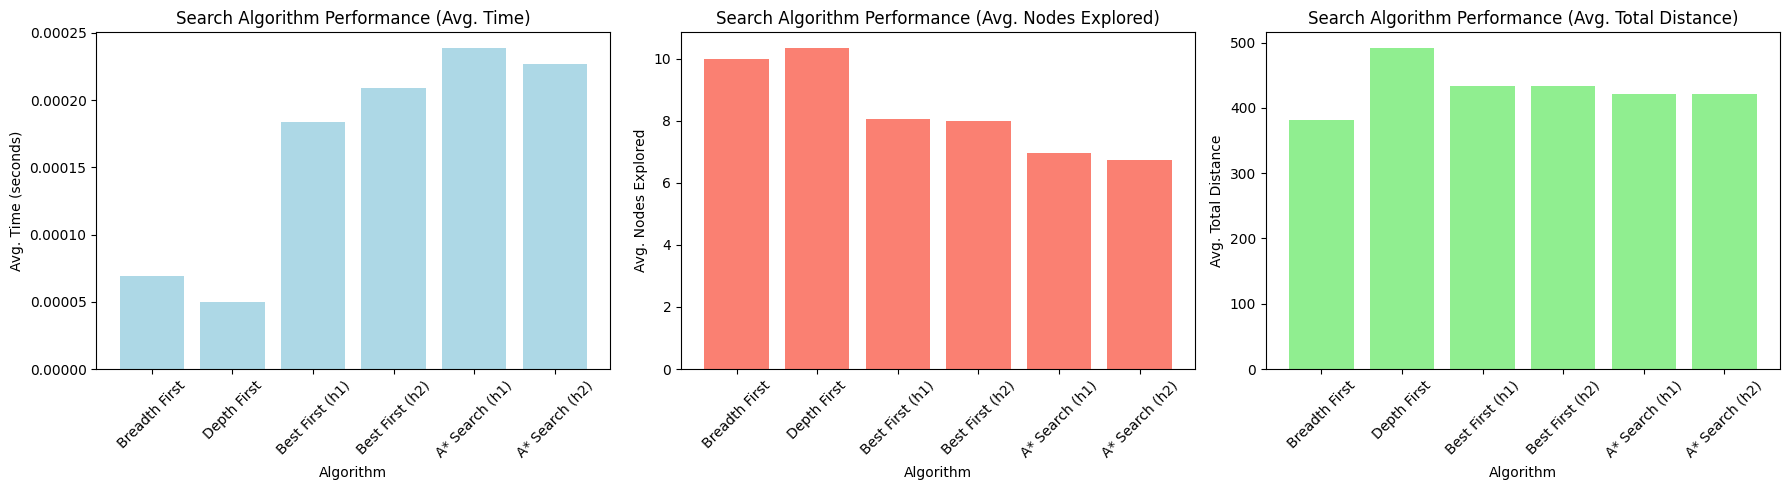

In [1]:
import timeit
import matplotlib.pyplot as plt
from queue import PriorityQueue
import gc
import random

class RomanianMap:
    """
    Represents the road map of Romania as an adjacency list.
    Provides methods to get neighboring cities and distances.
    """
    def __init__(self):
        # Initialize the map with cities and their neighbors along with distances
        self.map = {
            "Arad": [("Zerind", 75), ("Sibiu", 140), ("Timisoara", 118)],
            "Zerind": [("Arad", 75), ("Oradea", 71)],
            "Oradea": [("Zerind", 71), ("Sibiu", 151)],
            "Timisoara": [("Arad", 118), ("Lugoj", 111)],
            "Lugoj": [("Timisoara", 111), ("Mehadia", 70)],
            "Mehadia": [("Lugoj", 70), ("Drobeta", 75)],
            "Drobeta": [("Mehadia", 75), ("Craiova", 120)],
            "Craiova": [("Drobeta", 120), ("Rimnicu Vilcea", 146), ("Pitesti", 138)],
            "Sibiu": [("Arad", 140), ("Oradea", 151), ("Fagaras", 99), ("Rimnicu Vilcea", 80)],
            "Fagaras": [("Sibiu", 99), ("Bucharest", 211)],
            "Rimnicu Vilcea": [("Sibiu", 80), ("Craiova", 146), ("Pitesti", 97)],
            "Pitesti": [("Rimnicu Vilcea", 97), ("Craiova", 138), ("Bucharest", 101)],
            "Bucharest": [("Fagaras", 211), ("Pitesti", 101), ("Giurgiu", 90), ("Urziceni", 85)],
            "Giurgiu": [("Bucharest", 90)],
            "Urziceni": [("Bucharest", 85), ("Hirsova", 98), ("Vaslui", 142)],
            "Hirsova": [("Urziceni", 98), ("Eforie", 86)],
            "Eforie": [("Hirsova", 86)],
            "Vaslui": [("Urziceni", 142), ("Iasi", 92)],
            "Iasi": [("Vaslui", 92), ("Neamt", 87)],
            "Neamt": [("Iasi", 87)]
        }

    def calculate_total_distance(self, path):
        """
        Calculate the total distance of the given path by summing up the distances between consecutive cities.
        """
        total_distance = 0
        for i in range(len(path) - 1):
            neighbors = self.get_neighbors(path[i])
            for neighbor, distance in neighbors:
                if neighbor == path[i + 1]:
                    total_distance += distance
                    break
        return total_distance

    def get_neighbors(self, city):
        """
        Returns a list of tuples (neighboring_city, distance) for the given city.
        """
        return self.map.get(city, [])

    def get_all_cities(self):
        """
        Returns a list of all cities in the map.
        """
        return list(self.map.keys())

def heuristic_h1(romania_map, city, goal):
    """
    Simple heuristic (h1): Returns the minimum distance to a direct neighbor.
    """
    if city == goal:
        return 0  # Heuristic is zero at the goal

    neighbors = romania_map.get_neighbors(city)
    if not neighbors:
        return float('inf')

    return min([cost for _, cost in neighbors])

def heuristic_h2(romania_map, city, goal):
    """
    More complex heuristic (h2): Estimates the cost based on paths through two intermediate neighbors.
    """
    if city == goal:
        return 0  # Heuristic is zero at the goal

    min_cost = float('inf')
    for neighbor, cost_to_neighbor in romania_map.get_neighbors(city):
        for second_neighbor, cost_neighbor_to_second in romania_map.get_neighbors(neighbor):
            total_cost = cost_to_neighbor + cost_neighbor_to_second
            if total_cost < min_cost:
                min_cost = total_cost

    if min_cost == float('inf'):
        return heuristic_h1(romania_map, city, goal) * 2  # Fallback to h1 times 2
    else:
        return min_cost

def breadth_first_search(romania_map, start, goal):
    """
    Performs Breadth-First Search from start to goal.
    Returns the path found and the number of nodes explored.
    """
    from collections import deque
    queue = deque([start])
    visited = set([start])  # Add start to visited when enqueued
    parent = {start: None}
    nodes_explored = 0

    while queue:
        city = queue.popleft()
        nodes_explored += 1
        if city == goal:
            # Reconstruct path
            path = []
            while city is not None:
                path.append(city)
                city = parent[city]
            return path[::-1], nodes_explored  # Return reversed path
        for neighbor, _ in romania_map.get_neighbors(city):
            if neighbor not in visited:
                visited.add(neighbor)  # Mark neighbor as visited when enqueued
                parent[neighbor] = city
                queue.append(neighbor)
    return [], nodes_explored  # No path found


def depth_first_search(romania_map, start, goal):
    """
    Performs Depth-First Search from start to goal.
    Returns the path found and the number of nodes explored.
    """
    stack = [start]
    visited = set([start])  # Add start to visited when pushed to stack
    parent = {start: None}
    nodes_explored = 0

    while stack:
        city = stack.pop()
        nodes_explored += 1
        if city == goal:
            # Reconstruct path
            path = []
            while city is not None:
                path.append(city)
                city = parent[city]
            return path[::-1], nodes_explored  # Return reversed path
        for neighbor, _ in reversed(romania_map.get_neighbors(city)):
            if neighbor not in visited:
                visited.add(neighbor)  # Mark neighbor as visited when pushed
                parent[neighbor] = city
                stack.append(neighbor)
    return [], nodes_explored  # No path found


def best_first_search(romania_map, start, goal, heuristic):
    """
    Performs Best-First (Greedy) Search from start to goal using the given heuristic.
    Returns the path found and the number of nodes explored.
    """
    pq = PriorityQueue()
    #Begin at the starting node by visiting it and enqueuing to pq
    pq.put((heuristic(romania_map, start, goal), start))
    visited = set()
    parent = {start: None}
    nodes_explored = 0

    while not pq.empty():
        _, city = pq.get()
        if city not in visited:
            visited.add(city)
            nodes_explored += 1
            # If reached goal city, generate the path taken by gathering the respective parent nodes visited to reach goal
            if city == goal:
                path = []
                while city is not None:
                    path.append(city)
                    city = parent[city]
                return path[::-1], nodes_explored  # Return reversed path since it is currently listed as goal->start when we want start->goal

            # Otherwise, go to unvisited neighbors of current city node and enqueue to pq by (heuristic, node) which will automatically sort them by heuristic value
            for neighbor, _ in romania_map.get_neighbors(city):
                if neighbor not in visited:
                    parent[neighbor] = city
                    pq.put((heuristic(romania_map, neighbor, goal), neighbor))
    return [], nodes_explored  # No path found

def a_star_search(romania_map, start, goal, heuristic):
    """
    Performs A* Search from start to goal using the given heuristic.
    Returns the path found and the number of nodes explored.
    """
    # Early exit if start and goal are the same
    if start == goal:
        return [start], 0  # The path is just the start, and no nodes were explored

    pq = PriorityQueue()
    pq.put((heuristic(romania_map, start, goal), 0, start))  # (f(n), g(n), city)
    visited = set()
    parent = {start: None}
    g_scores = {start: 0}
    nodes_explored = 0

    while not pq.empty():
        f, g, city = pq.get()

        # If we reach the goal, reconstruct the path
        if city == goal:
            path = []
            while city is not None:
                path.append(city)
                city = parent.get(city)
            return path[::-1], nodes_explored  # Return reversed path

        # If this node has already been visited, skip it
        if city in visited:
            continue

        # Mark the city as visited
        visited.add(city)
        nodes_explored += 1

        # Explore neighbors
        for neighbor, cost in romania_map.get_neighbors(city):
            tentative_g_score = g + cost

            # If the neighbor has not been visited or we've found a better g-score
            if neighbor not in visited or tentative_g_score < g_scores.get(neighbor, float('inf')):
                g_scores[neighbor] = tentative_g_score
                f_score = tentative_g_score + heuristic(romania_map, neighbor, goal)

                # Update the parent dictionary correctly
                parent[neighbor] = city  # Set the parent of the neighbor to the current city

                pq.put((f_score, tentative_g_score, neighbor))

    # If we exhaust the priority queue without finding the goal
    return [], nodes_explored  # No path found




class TestingClass:
    """
    A class to test various search algorithms on the Romanian map.
    Provides methods to run searches, test all algorithms, and graph results.
    """
    def __init__(self, search_algorithms):
        self.romania_map = RomanianMap()  # Using the RomanianMap class
        self.search_algorithms = search_algorithms  # A dictionary of search algorithms

    def run_search(self, algorithm_name, start, goal):
        """
        Runs a specific search algorithm from start to goal.
        Returns the time taken, the path found, and the number of nodes explored.
        """
        algorithm = self.search_algorithms[algorithm_name]

        # Wrapper function to run the search algorithm
        def search_func():
            return algorithm(self.romania_map, start, goal)

        # Measure the time using timeit with number=1 for accurate timing
        elapsed_time = timeit.timeit(search_func, number=1)
        path, nodes_explored = search_func()  # Get the result of the search

        # Clear memory after search
        del search_func
        gc.collect()

        return elapsed_time, path, nodes_explored

    def test_all_algorithms(self, iterations):
        """
        Tests all algorithms in the search_algorithms dictionary across a number of iterations.
        Returns a dictionary with algorithm names as keys and total execution times, nodes explored, and distances.
        """
        # Initialize results dictionary
        results = {algo_name: {'total_time': 0, 'total_nodes': 0, 'total_distance': 0} for algo_name in self.search_algorithms}

        # Get list of all cities once before the iterations
        all_cities = self.romania_map.get_all_cities()

        for _ in range(iterations):
            # Randomly select start and goal cities (ensure they are not the same)
            start, goal = random.sample(all_cities, 2)

            for algo_name in self.search_algorithms:
                elapsed_time, path, nodes_explored = self.run_search(algo_name, start, goal)
                total_distance = self.romania_map.calculate_total_distance(path) if path else 0

                # Accumulate results in the dictionary
                results[algo_name]['total_time'] += elapsed_time
                results[algo_name]['total_nodes'] += nodes_explored
                results[algo_name]['total_distance'] += total_distance

                # Clear memory after each algorithm run
                del path, nodes_explored, total_distance
                gc.collect()

            # Clear memory after each iteration
            del start, goal
            gc.collect()

        # Final cleanup after all iterations
        del all_cities
        gc.collect()

        return results

    def graph_results(self, results, iterations):
        """
        Plots the performance of each algorithm in terms of time, nodes explored, and total distance across multiple iterations.
        """
        algorithms = list(results.keys())
        execution_times = [results[algo]['total_time'] / iterations for algo in algorithms]  # Average time
        nodes_explored = [results[algo]['total_nodes'] / iterations for algo in algorithms]  # Average nodes
        total_distances = [results[algo]['total_distance'] / iterations for algo in algorithms]  # Average distance

        # Creating subplots for time, nodes explored, and total distance
        plt.figure(figsize=(18, 5))

        # Plotting execution times
        plt.subplot(1, 3, 1)
        plt.bar(algorithms, execution_times, color='lightblue')
        plt.xlabel('Algorithm')
        plt.ylabel('Avg. Time (seconds)')
        plt.title('Search Algorithm Performance (Avg. Time)')
        plt.xticks(rotation=45)

        # Plotting nodes explored
        plt.subplot(1, 3, 2)
        plt.bar(algorithms, nodes_explored, color='salmon')
        plt.xlabel('Algorithm')
        plt.ylabel('Avg. Nodes Explored')
        plt.title('Search Algorithm Performance (Avg. Nodes Explored)')
        plt.xticks(rotation=45)

        # Plotting total distances
        plt.subplot(1, 3, 3)
        plt.bar(algorithms, total_distances, color='lightgreen')
        plt.xlabel('Algorithm')
        plt.ylabel('Avg. Total Distance')
        plt.title('Search Algorithm Performance (Avg. Total Distance)')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        # Clear memory after graphing
        del algorithms, execution_times, nodes_explored, total_distances
        gc.collect()

# Define the search algorithms dictionary
search_algorithms = {
    "Breadth First": breadth_first_search,
    "Depth First": depth_first_search,
    "Best First (h1)": lambda map, start, goal: best_first_search(map, start, goal, heuristic=heuristic_h1),
    "Best First (h2)": lambda map, start, goal: best_first_search(map, start, goal, heuristic=heuristic_h2),
    "A* Search (h1)": lambda map, start, goal: a_star_search(map, start, goal, heuristic=heuristic_h1),
    "A* Search (h2)": lambda map, start, goal: a_star_search(map, start, goal, heuristic=heuristic_h2),
}

# Create an instance of TestingClass
tester = TestingClass(search_algorithms)

# Define number of iterations
num_iterations = 30

# Test all algorithms over multiple iterations
results = tester.test_all_algorithms(num_iterations)

# Print results
for algo in results:
    print(f"Algorithm: {algo}")
    print(f"Total time taken: {results[algo]['total_time']:.6f} seconds")
    print(f"Total nodes explored: {results[algo]['total_nodes']}")
    print(f"Total distance: {results[algo]['total_distance']:.2f} units")
    print()

# Graph the results (average over iterations)
tester.graph_results(results, num_iterations)

